In [1]:
import os
os.chdir(os.getenv("WORKINGDIR"))
import numpy as np
from numpy.typing import ArrayLike
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
from skipper_image_analysis.utils import (
    plot_ccd_image, correct_overscan, get_rowcol_ovserscan
)
from scipy.optimize import curve_fit

# Matplotlib settings
%config InlineBackend.figure_format = "retina"  # For high dpi figures in notebook
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["figure.dpi"] = 120
plt.rcParams["legend.fontsize"] = "medium"
plt.rcParams["axes.labelsize"] = "large"


ganancia = {
    0: 210,
    1: 232,
    2: 207,
    3: 159
}
PRESCAN_PIX = 8

# Detección de dipolos

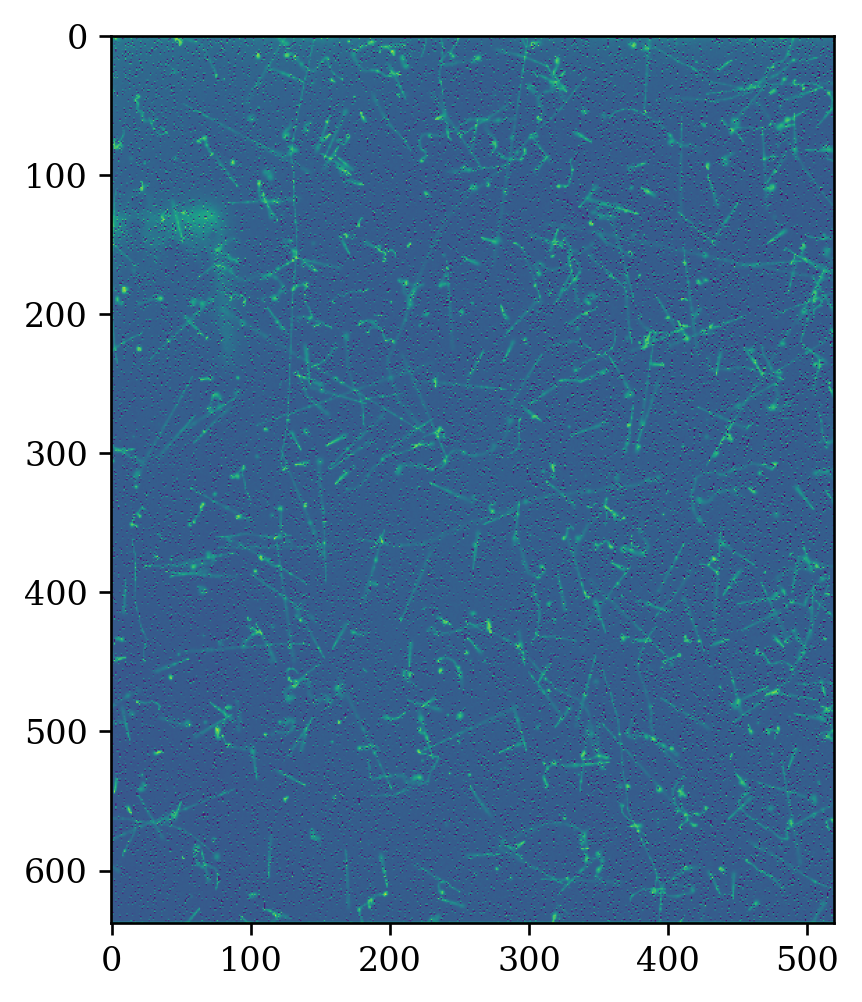

43424


In [51]:
plt.close("all")
%matplotlib inline
data_dir = 'skipper_data\Imagenes_Santi'
t_ilum = 0.25
threshold = 0.1e10
#test_image = fits.open(f'{data_dir}\proc_skp_mod45_2ndbatch_T150_Vv2_seqrevOS_vdd-17_loopdtph_wledon140_npump40000_dtph100_NSAMP10_NROW650_NCOL650_EXPOSURE0_NBINROW1_NBINCOL1_img40.fits')
test_image = fits.open(f'{data_dir}\proc_skp_mod45_2ndbatch_T150_Vv2_seqrevOS_vdd-17_loopdtph_wledon140_npump40000_dtph2000000_NSAMP10_NROW650_NCOL650_EXPOSURE0_NBINROW1_NBINCOL1_img58.fits')
#test_image = correct_overscan(test_image)
test_frame = test_image[0].data
r_overscan, c_overscan = get_rowcol_ovserscan(test_image)
test_frame = test_frame[1:-r_overscan, PRESCAN_PIX+1:-c_overscan]
test_frame = test_frame-np.median(test_frame, axis=0)
dif_1 = np.diff(test_frame, axis=0, )
dif_2 = np.diff(test_frame[::-1], axis=0, )[::-1]
mascara_dipolos = np.zeros_like(dif_1, dtype=int)

prod_arr = test_frame[:-1] * test_frame[1:]
#prod_arr = dif_1 * dif_2
mascara_dipolos[prod_arr>=-threshold] = 0
mascara_dipolos[prod_arr<-threshold] = 1
coordenadas_trampas = []
for j, col in enumerate(prod_arr.T):
    for i, val in enumerate(col):
        if mascara_dipolos[i, j] == 1:
            if i == 0:
                i_lleno = np.argmax(test_frame[i:i+2, j])
                i_lleno = i_lleno + i - 1
                i_vacio = np.argmin(test_frame[i:i+2, j])
                i_vacio = i_vacio + i - 1
            elif i == len(col):
                i_lleno = np.argmax(test_frame[i-1:i+1, j])
                i_lleno = i_lleno + i - 1
                i_vacio = np.argmin(test_frame[i-1:i+1, j])
                i_vacio = i_vacio + i - 1
            else:
                i_lleno = np.argmax(test_frame[i-1:i+2, j])
                i_lleno = i_lleno + i - 1
                i_vacio = np.argmin(test_frame[i-1:i+2, j])
                i_vacio = i_vacio + i - 1
            coordenadas_trampas.append(((i_lleno, j), (i_vacio, j)))
#
# filtro_dipolos
#plt.imshow(np.log(np.abs(dif_1)+1))
plt.imshow(test_frame)
#plt.colorbar()

plt.show()

#plt.imshow(prod_arr)
#plt.colorbar()
#plt.show()
#plt.imshow(np.log(np.abs(mascara_dipolos)+1))
#plt.colorbar()
#plt.show()
#plt.imshow(np.log(np.abs(test_frame)+1))
#plt.imshow(test_frame)
#plt.colorbar()
#plt.show()
print(len(coordenadas_trampas))

In [29]:
plt.close('all')

C:\Users\Usuario\AppData\Local\Temp\ipykernel_24180\1358130242.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(colors)


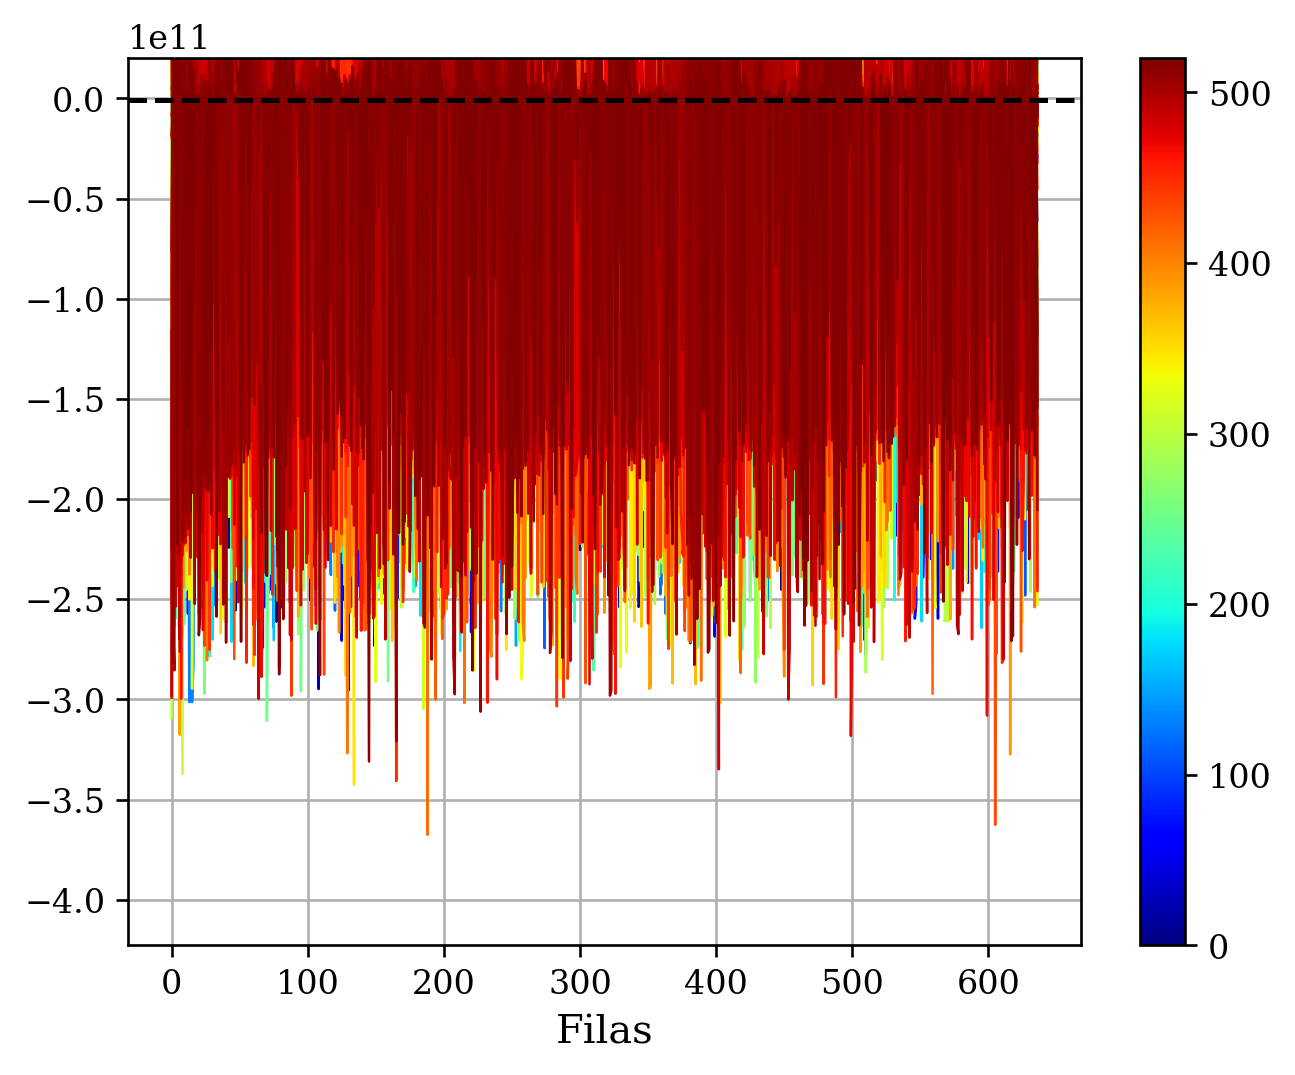

In [52]:
plt.close('all')
%matplotlib inline
colors = plt.cm.ScalarMappable(norm=plt.Normalize(0, prod_arr.shape[1]),
                               cmap="jet")
for j, col in enumerate(prod_arr.T):
    #if j <100 : 
    #    plt.plot(col, color = 'k')
    #if j >= 100 and j < 200 : 
    #    plt.plot(col, color = 'b')
    #if j >=200 and j< 300: 
    #    plt.plot(col, color = 'g')
    #if j >= 300 and j < 400 : 
    #    plt.plot(col, color = 'm')
    #if j >= 400 and j < 500 : 
    #    plt.plot(col, color = 'r')
    #if j > 500:
    #    plt.plot(col, color = 'c') 
    plt.plot(col, lw=0.75, color=colors.to_rgba(j))
    
    #for i, val in enumerate(col):
    #    if val < -threshold:
    #        print(i, j)
#for col in dif_1.T:
#    plt.plot(col)
plt.xlabel("Filas")
#plt.axhline(threshold, xmin = 0, xmax = 828, ls = '--', color='k')
plt.axhline(-threshold, xmin = 0, xmax = 828, ls ='--', color = 'k')
plt.ylim(top= 0.2e11 )
plt.colorbar(colors)
plt.grid()
plt.show()
#for j, col in enumerate(test_frame.T):
#    if j <100 : 
#        plt.plot(col, color = 'k')
#    if j >= 100 and j < 200 : 
#        plt.plot(col, color = 'b')
#    if j >=200 and j< 300: 
#        plt.plot(col, color = 'g')
#    if j >= 300 and j < 400 : 
#        plt.plot(col, color = 'm')
#    if j >= 400 and j < 500 : 
#        plt.plot(col, color = 'r')
#    if j > 500:
#        plt.plot(col, color = 'c') 

#plt.xlabel("Filas")
#plt.show()

  0%|          | 0/43424 [00:00<?, ?it/s]

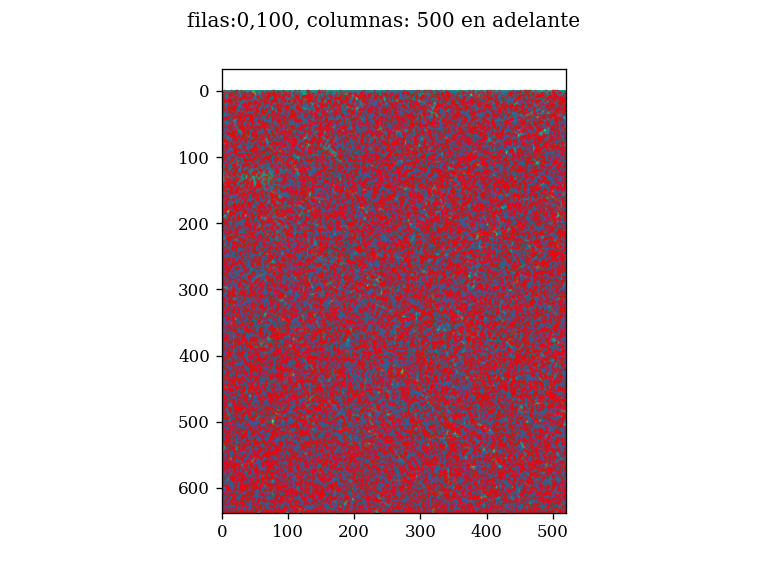

In [53]:
from tqdm.notebook import tqdm
plt.close('all')
%matplotlib widget
#fig, axs = plt.subplots(1, 2)
fig, ax = plt.subplots(1, 1)
i_min, i_max = 0, 100
fig.suptitle(f'filas:{i_min},{i_max}, columnas: 500 en adelante')
ax.imshow(test_frame)
for trampa in tqdm(coordenadas_trampas):
    fila_vals = [coord[0] for coord in trampa]
    col_vals = [coord[1] for coord in trampa]
    ax.plot(col_vals, fila_vals, '.r', ms=1, alpha=0.5) 
#axs[1].imshow(mascara_dipolos)
plt.show()
if False:
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(test_frame[0:100, 400:500])
    axs[1].imshow(mascara_dipolos[0:100, 400:500])
    plt.show()

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(test_frame[0:100, 200:300])
    axs[1].imshow(mascara_dipolos[0:100, 200:300])
    plt.show()
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(test_frame[0:100, 200:300])
    axs[1].imshow(mascara_dipolos[0:100, 200:300])
    plt.show()